# Tick library - guide and testing

## Python Imports

In [ ]:
import numpy as np
import pandas as pd
# import matplotlib.pyplot as plt

## Tick Imports

In [ ]:
from tick.hawkes import SimuHawkes, SimuHawkesMulti
from tick.base import TimeFunction
from tick.hawkes import HawkesKernelTimeFunc
from tick.hawkes import HawkesKernelSumExp
from tick.hawkes import HawkesEM, HawkesSumExpKern
# from tick.hawkes import HawkesBasisKernels, HawkesSumGaussians
from tick.plot import plot_timefunction
from tick.plot import plot_point_process
from tick.plot import plot_hawkes_kernels
from tick.plot import plot_basis_kernels

## Defining Time Functions

In [ ]:
support = 4
t0 = 0.01
n_steps = int(support/t0)*10

#### Using a function

In [ ]:
def g1(t):
    return 0.7 * 5.0 * np.exp(-5.0 * t)

Introducing a latency with heaviside

In [ ]:
def g2(t):
    return 0.7 * 5.0 * np.exp(-5.0 * (t - t0))\
        * np.heaviside(t - t0, 1) # To ensure zero before t0

### Creating a complete function with latency and linear interpolation

In [ ]:
def time_func(f, support, t0=0, steps=1000):
    t_values = np.linspace(0, support, steps + 1)
    y_values = f(t_values - t0) * np.heaviside(t_values - t0, 1)
    return TimeFunction(values=(t_values, y_values),
                        border_type=TimeFunction.Border0,
                        inter_mode=TimeFunction.InterLinear)

In [ ]:
tf_1 = time_func(g1, support, 0, n_steps)

In [ ]:
tf_2 = time_func(g1, support, t0, n_steps)

In [ ]:
print([[tf_1.value(0), tf_1.value(1)], [tf_2.value(t0), tf_2.value(1+t0)]])

In [ ]:
plot_timefunction(tf_1)

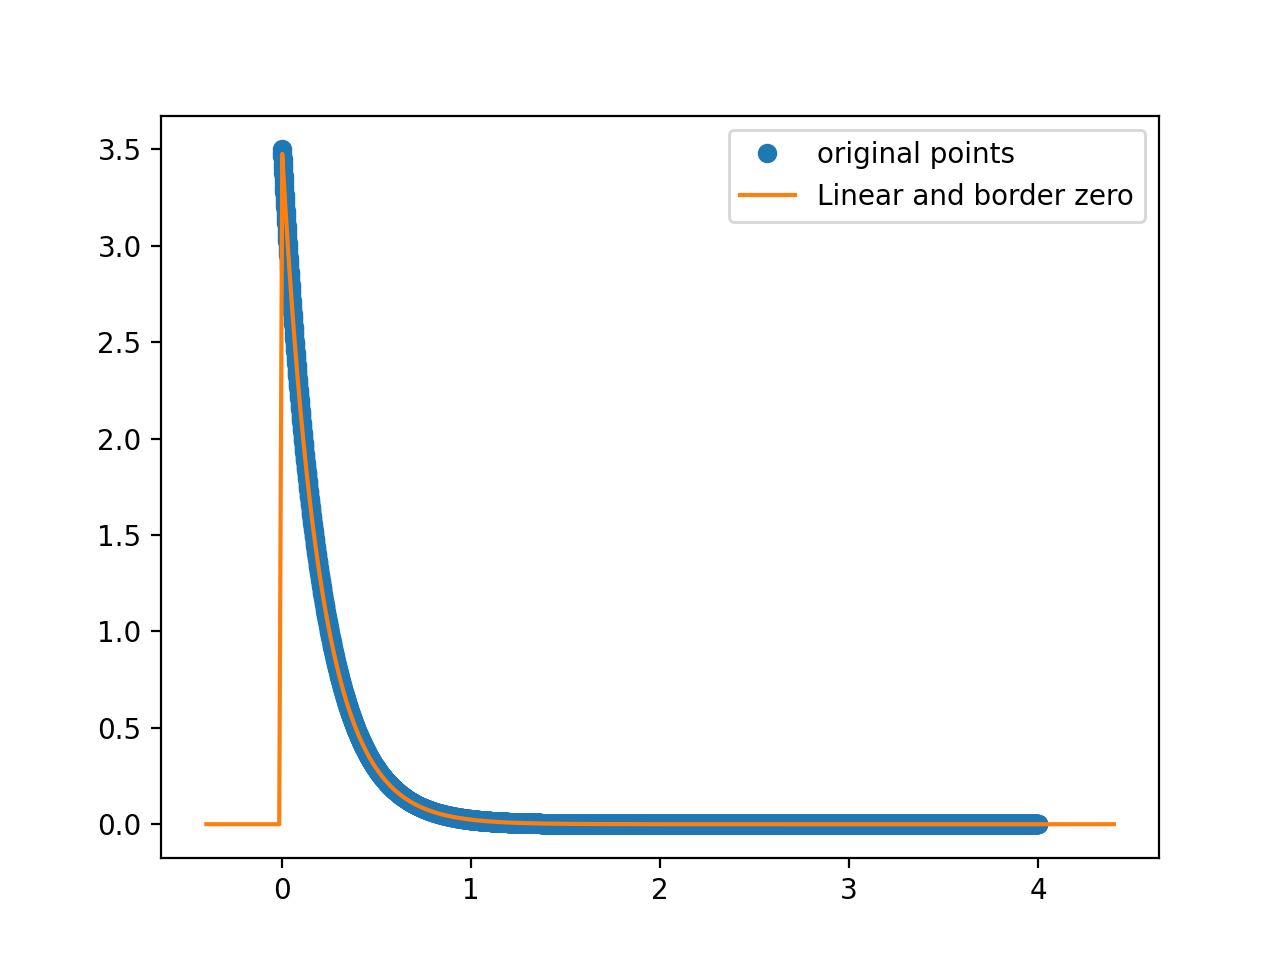

In [ ]:
plot_timefunction(tf_2)

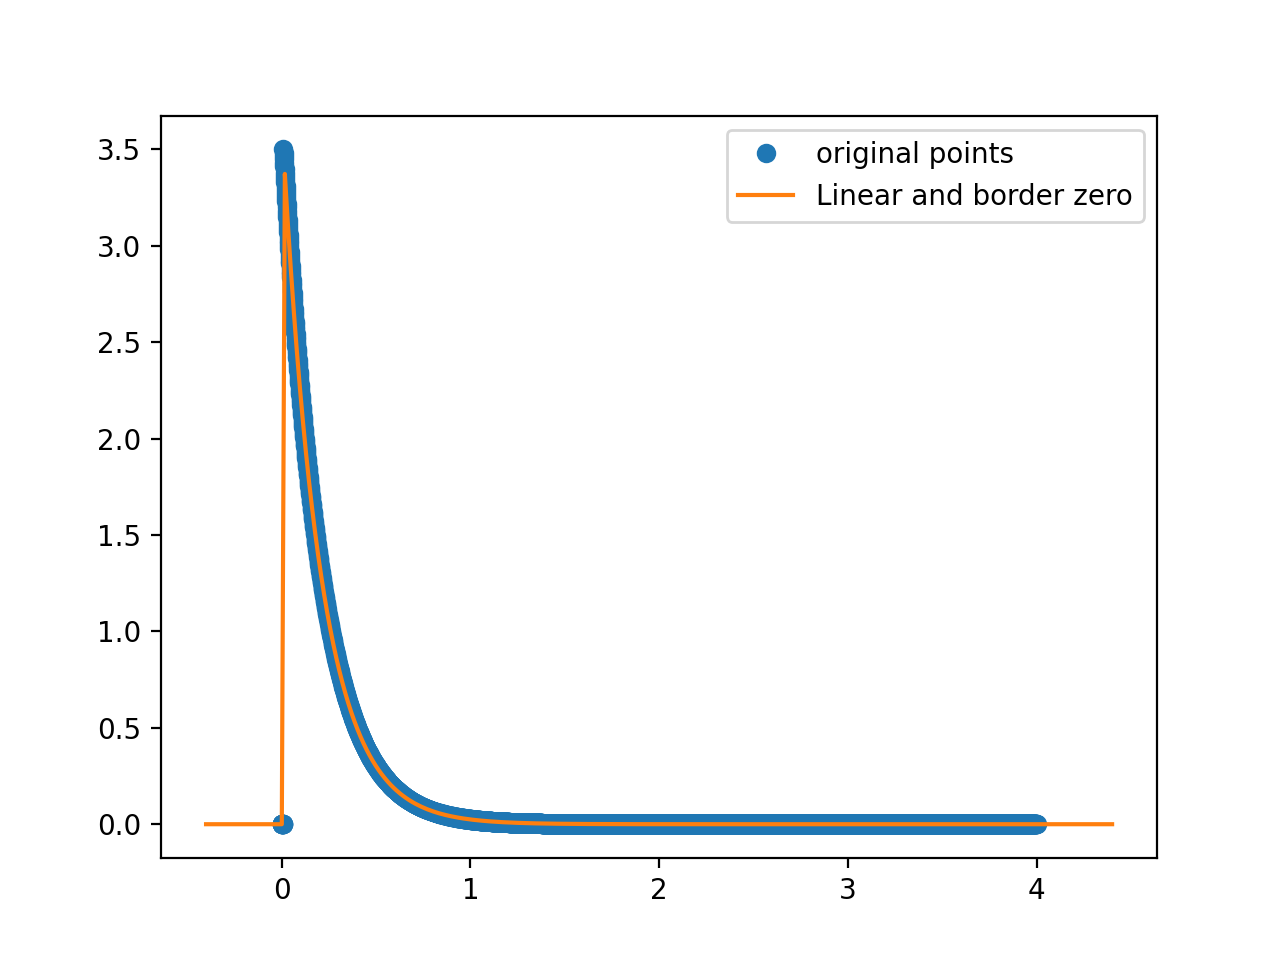

## Defining Non-parametric Kernels

In [ ]:
kernel_1 = HawkesKernelTimeFunc(tf_1)

In [ ]:
kernel_2 = HawkesKernelTimeFunc(tf_2)

## Defining Parametric Kernels

In [ ]:
# kernel_sumexp = HawkesKernelSumExp(
#     intensities=np.array([0.1, 0.2, 0.1]),
#     decays=np.array([1.0, 3.0, 7.0]))

## Simulations

### SimuHawkes

In [ ]:
# hawkes = SimuHawkes(n_nodes=1, end_time=40, seed=1398)
# hawkes.set_kernel(0, 0, kernel_sumexp)
# hawkes.set_baseline(0, 1.)

In [ ]:
# dt = 0.01
# hawkes.track_intensity(dt)
# hawkes.simulate()

In [ ]:
# timestamps = hawkes.timestamps
# intensity = hawkes.tracked_intensity
# intensity_times = hawkes.intensity_tracked_times
# mean_intensity = hawkes.mean_intensity()

In [ ]:
# pd.Series(np.arange(1, len(timestamps[0])+1),
#           index=timestamps[0]).plot(drawstyle='steps-post')

In [ ]:
# plot_point_process(hawkes)

### SimuHawkesMulti

In [ ]:
hawkes_m1 = SimuHawkes(n_nodes=1, end_time=10000)
hawkes_m1.set_baseline(0, 1.)

hawkes_m2 = SimuHawkes(n_nodes=1, end_time=10000)
hawkes_m2.set_baseline(0, 1.)

hawkes_m1.set_kernel(0, 0, kernel_1)
hawkes_m2.set_kernel(0, 0, kernel_2)

In [ ]:
multi_1 = SimuHawkesMulti(hawkes_m1, n_simulations=100)
multi_1.simulate()

multi_2 = SimuHawkesMulti(hawkes_m2, n_simulations=100)
multi_2.simulate()

In [ ]:
multi_1_timestamps = multi_1.timestamps
# multi_1_mean_intensity = multi_1.mean_intensity

multi_2_timestamps = multi_2.timestamps
# multi_2_mean_intensity = multi_2.mean_intensity

## Learning

#### Non-parametric

##### HawkesEM

In [ ]:

kern_d =\
    np.concatenate(
        (np.array([0., 0.2*t0,  0.5*t0, 0.75*t0, 0.9*t0, t0, 1.25*t0, 1.5*t0]),
         np.array([0.02, 0.05, 0.075, 0.1, 0.2, 0.5, 0.75, 1., 2.,
                   support])))

In [ ]:

em_1 = HawkesEM(kernel_discretization=kern_d, max_iter=10000, tol=1e-5,
                verbose=True, n_threads=-1)
em_1.fit(multi_1_timestamps)
em_1_baseline = em_1.baseline
em_1_kernel = em_1.kernel
em_1_score = em_1.score()

In [ ]:

em_2 = HawkesEM(kernel_discretization=kern_d, max_iter=10000, tol=1e-5,
                verbose=True, n_threads=-1)
em_2.fit(multi_2_timestamps)
em_2_baseline = em_2.baseline
em_2_kernel = em_2.kernel
em_2_score = em_2.score()

In [ ]:

print(pd.DataFrame(
    {'0': em_1_kernel[0, 0],
     't0': em_2_kernel[0, 0]}).head(10))

In [ ]:
plot_hawkes_kernels(em_1, hawkes=hawkes_m1)

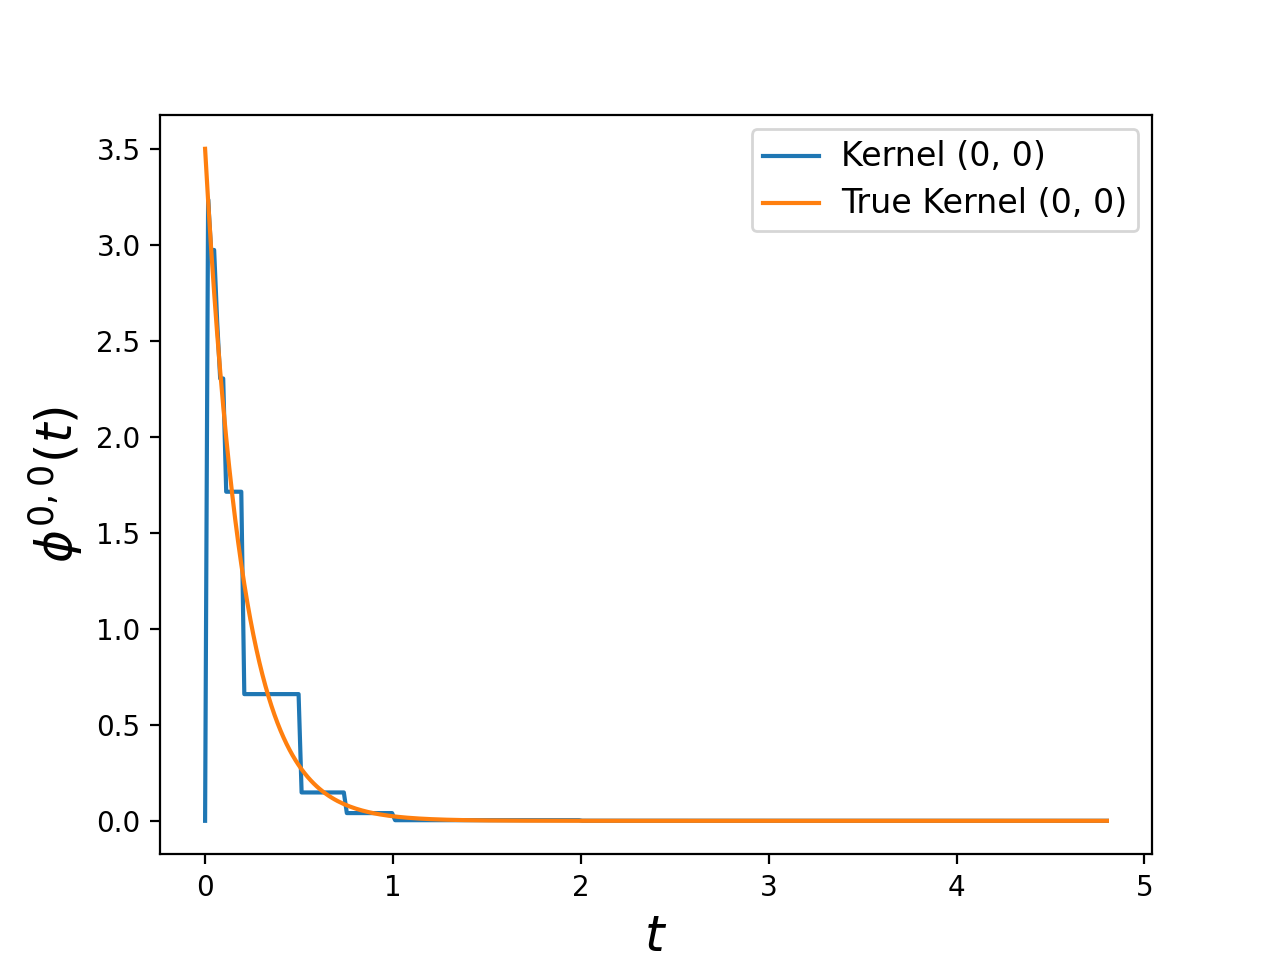

In [ ]:
plot_hawkes_kernels(em_1, hawkes=hawkes_m1, log_scale=True)

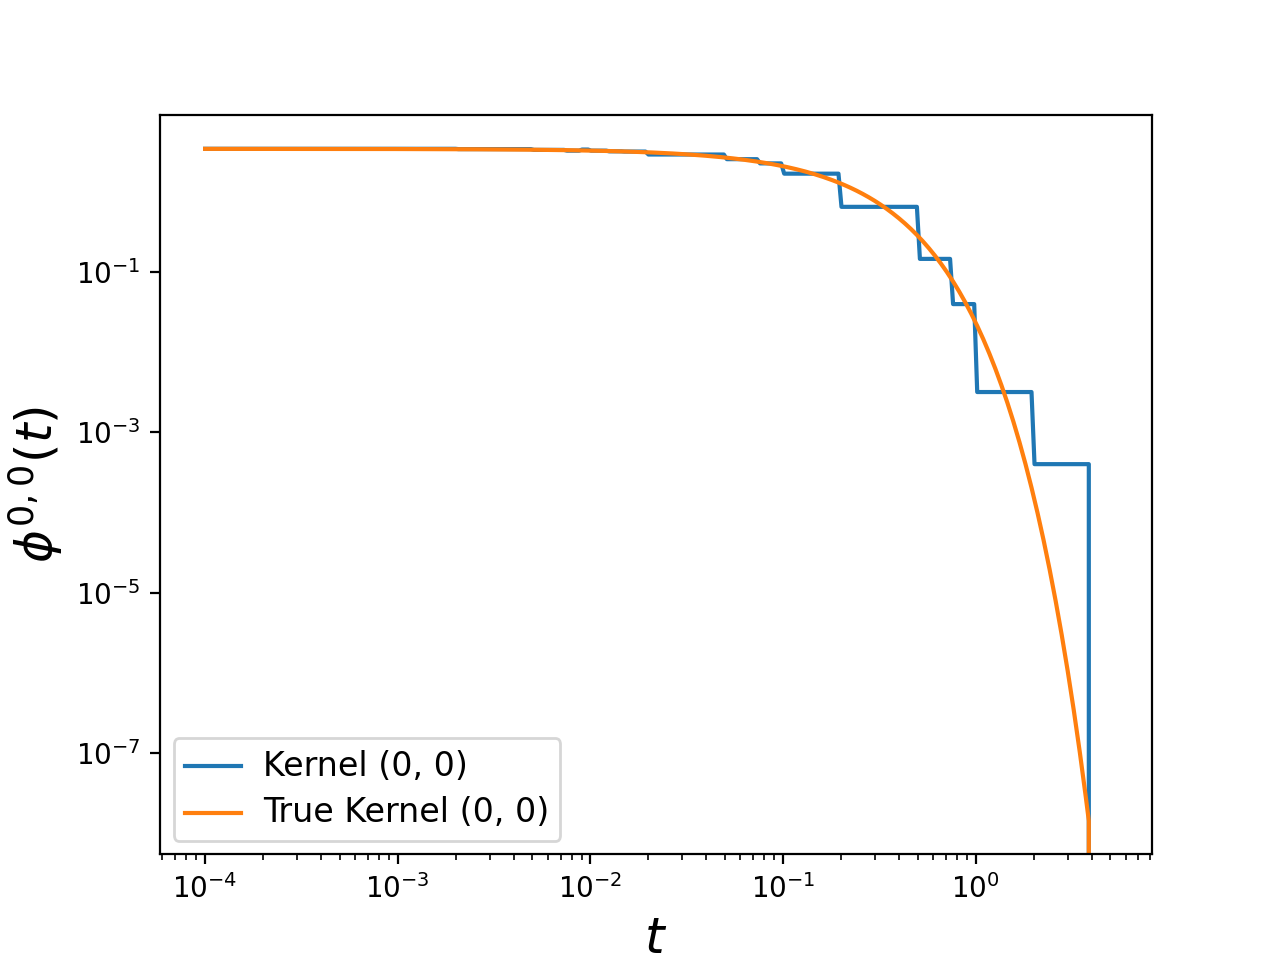

In [ ]:
plot_hawkes_kernels(em_2, hawkes=hawkes_m2)

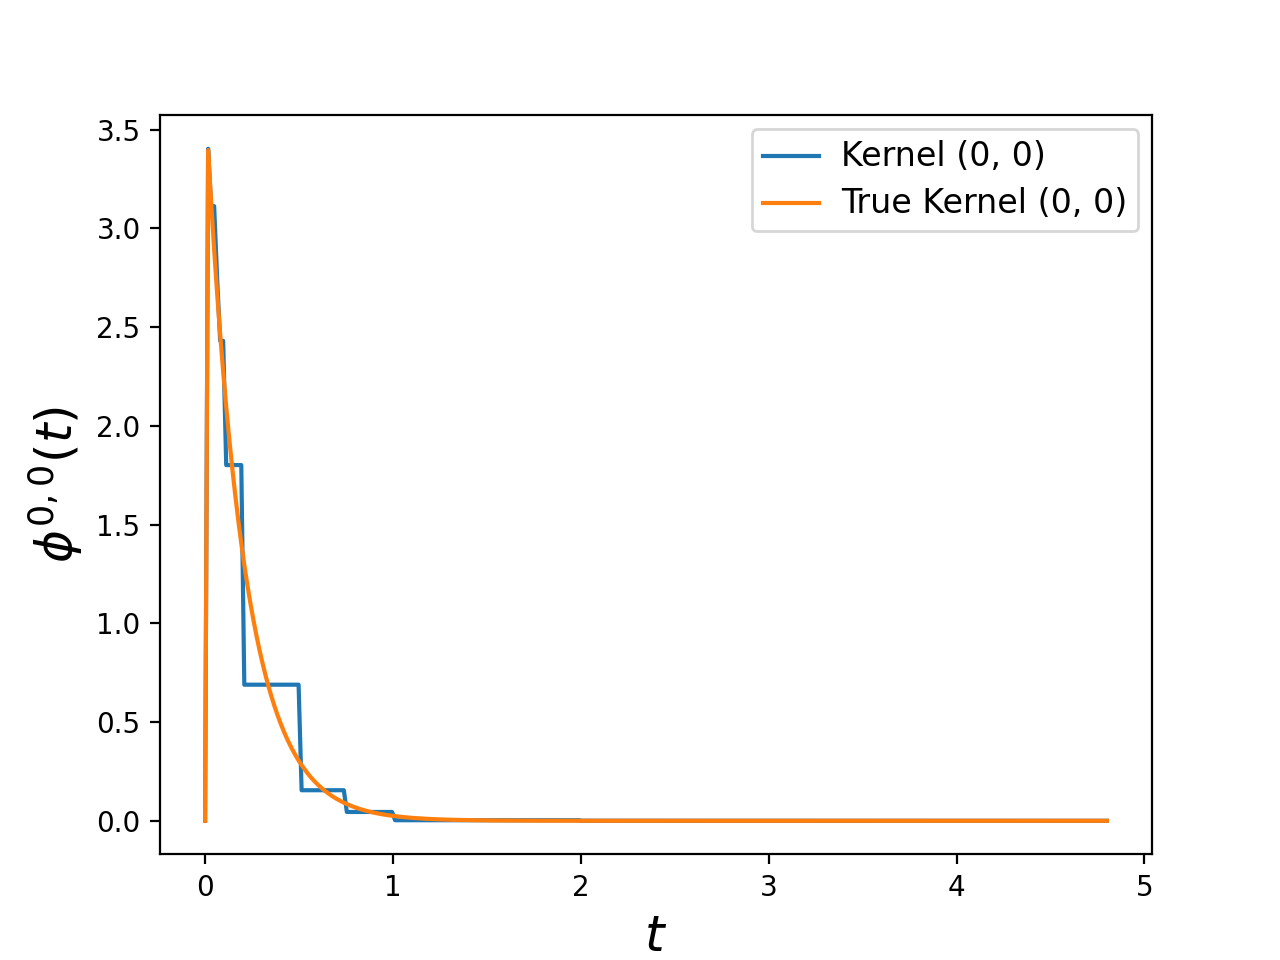

In [ ]:
plot_hawkes_kernels(em_2, hawkes=hawkes_m2, log_scale=True)

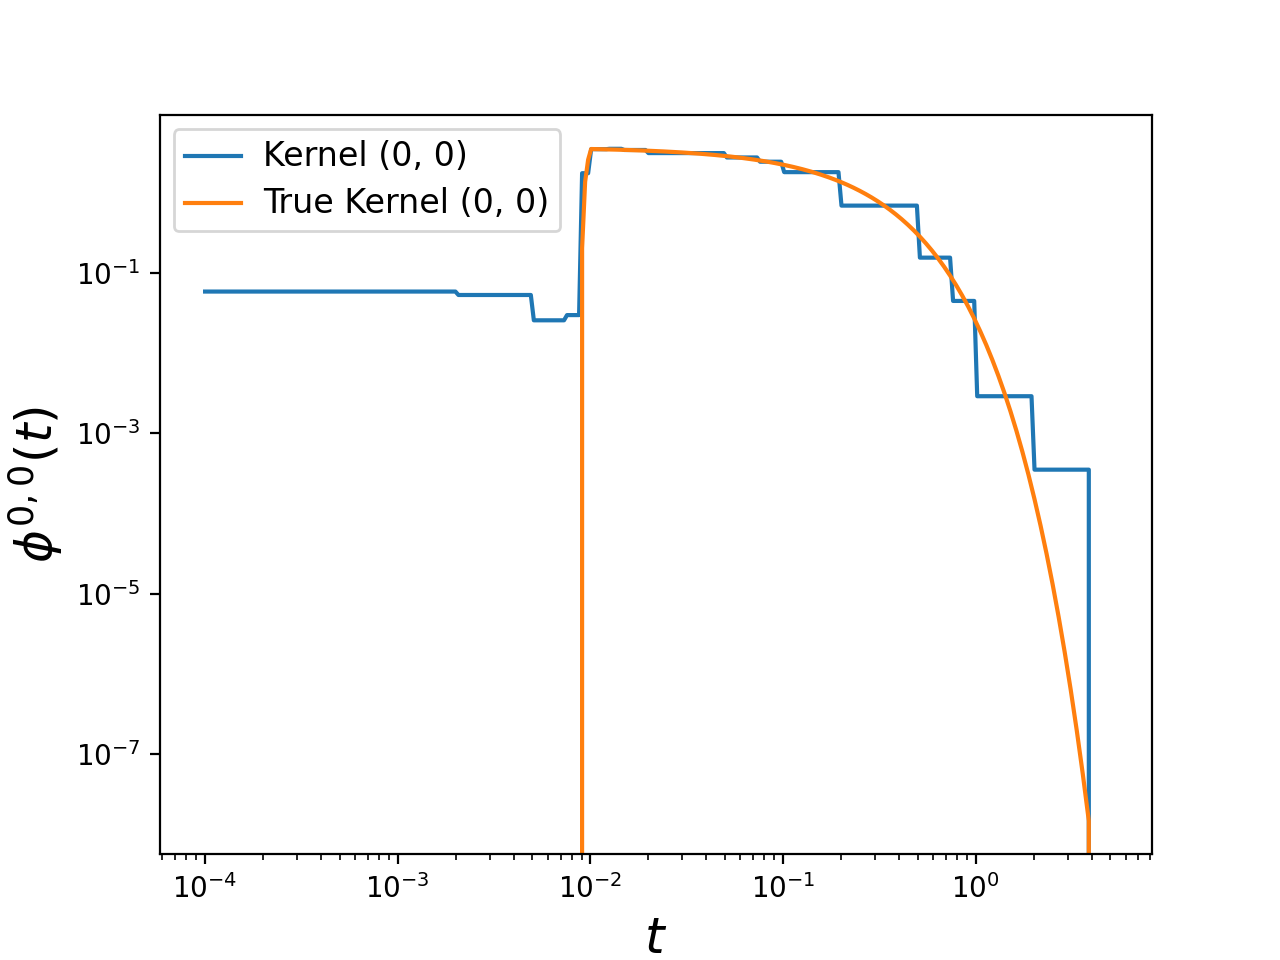

##### HawkesBasisKernels

In [ ]:

# bk_1 = HawkesBasisKernels(kernel_support=4, n_basis=1, kernel_size=100,
#                           max_iter=10000, tol=1e-5, C=0.1, verbose=True,
#                           n_threads=-1)
# bk_1.fit(multi_1_timestamps)
# bk_1_baseline = bk_1.baseline
# bk_1_amplitudes = bk_1.amplitudes
# bk_1_kernel = bk_1.basis_kernels

# bk_2 = HawkesBasisKernels(kernel_support=4, n_basis=1, kernel_size=100,
#                           max_iter=10000, tol=1e-5, C=0.1, verbose=True,
#                           n_threads=-1)
# bk_2.fit(multi_2_timestamps)
# bk_2_baseline = bk_2.baseline
# bk_2_amplitudes = bk_2.amplitudes
# bk_2_kernel = bk_2.basis_kernels

In [ ]:
# plot_hawkes_kernels(bk_1, hawkes=hawkes_m1)

In [ ]:
# plot_hawkes_kernels(bk_2, hawkes=hawkes_m2)

In [ ]:
# plot_basis_kernels(bk, basis_kernels=[g1, g2])

#### Parametric

##### HawkesSumExpKern

In [ ]:

sek_1 = HawkesSumExpKern(decays=[5.],
                         n_baselines=1, penalty='l2', solver='agd',
                         elastic_net_ratio=0.8,
                         max_iter=10000, tol=1e-5, C=1000., verbose=True)
sek_1.fit(multi_1_timestamps)
sek_1_baseline = sek_1.baseline
sek_1_adjacency = sek_1.adjacency
sek_1_score = sek_1.score()

In [ ]:

sek_2 = HawkesSumExpKern(decays=[5.],
                         n_baselines=1, penalty='l2', solver='agd',
                         elastic_net_ratio=0.8,
                         max_iter=10000, tol=1e-5, C=1000., verbose=True)
sek_2.fit(multi_2_timestamps)
sek_2_baseline = sek_2.baseline
sek_2_adjacency = sek_2.adjacency
sek_2_score = sek_2.score()

In [ ]:
plot_hawkes_kernels(sek_1, hawkes=hawkes_m1)

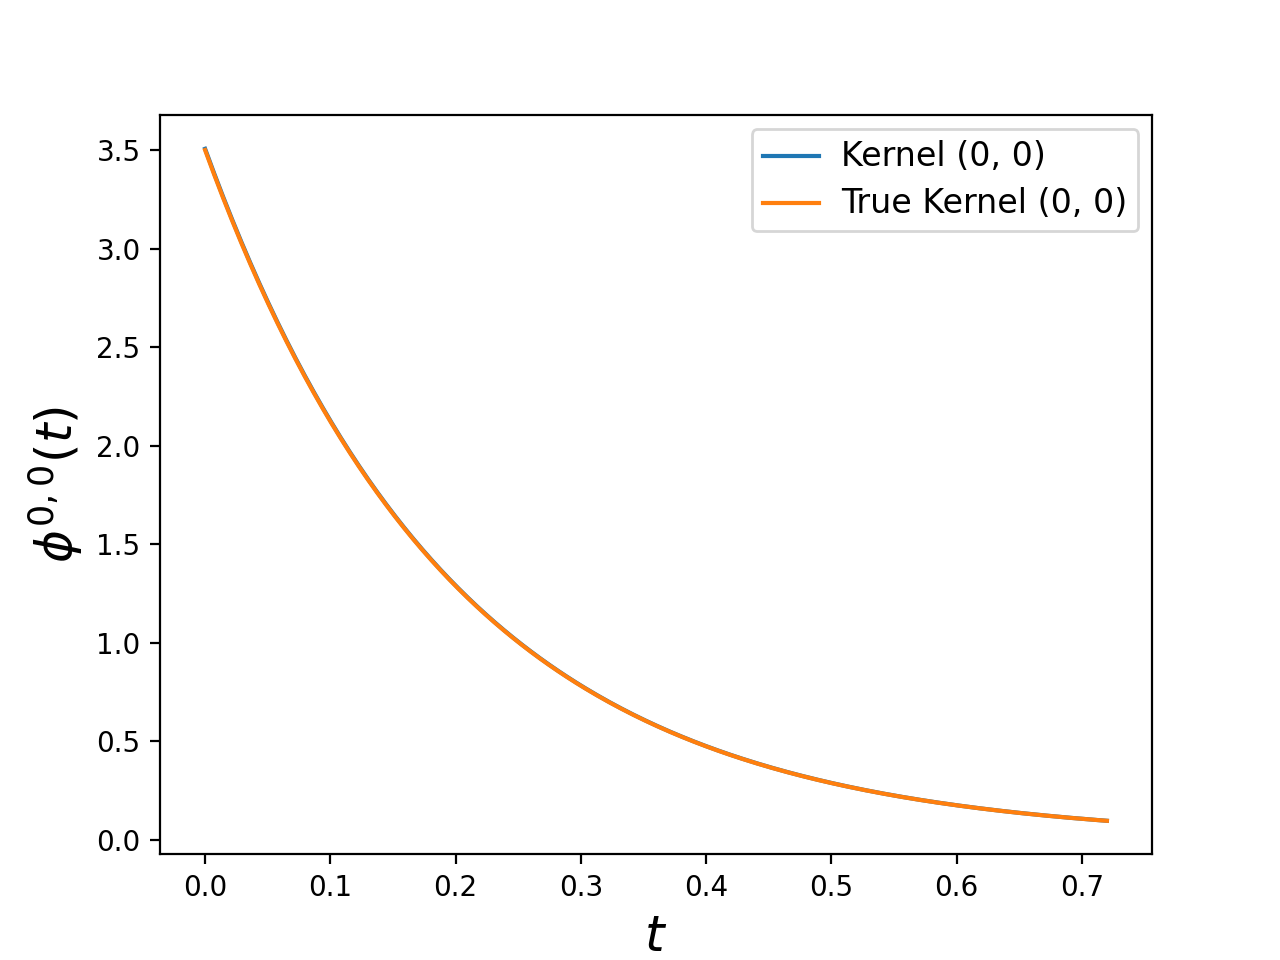

In [ ]:
plot_hawkes_kernels(sek_1, hawkes=hawkes_m1, log_scale=True)

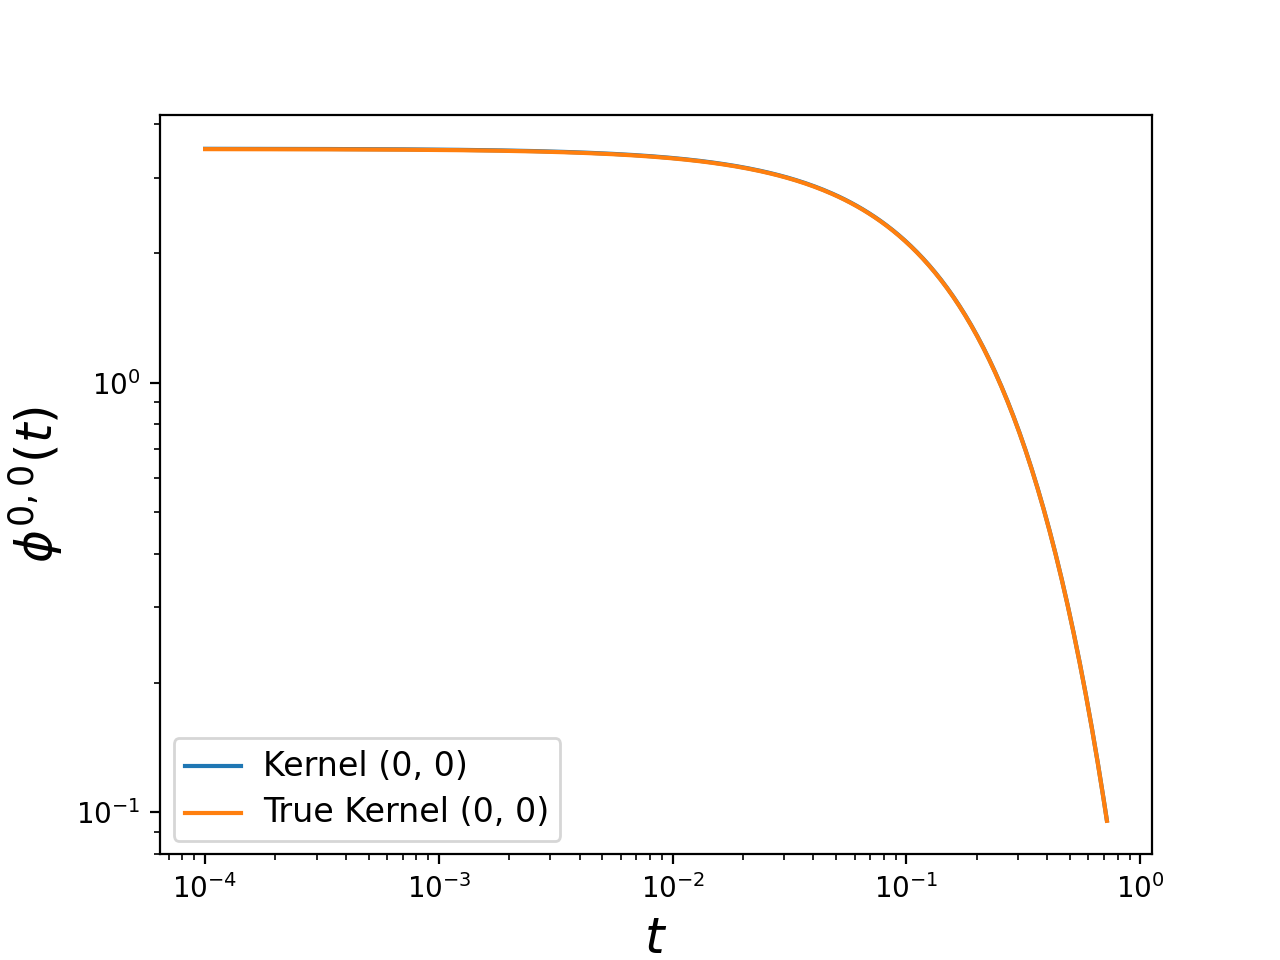

In [ ]:
plot_hawkes_kernels(sek_2, hawkes=hawkes_m2)

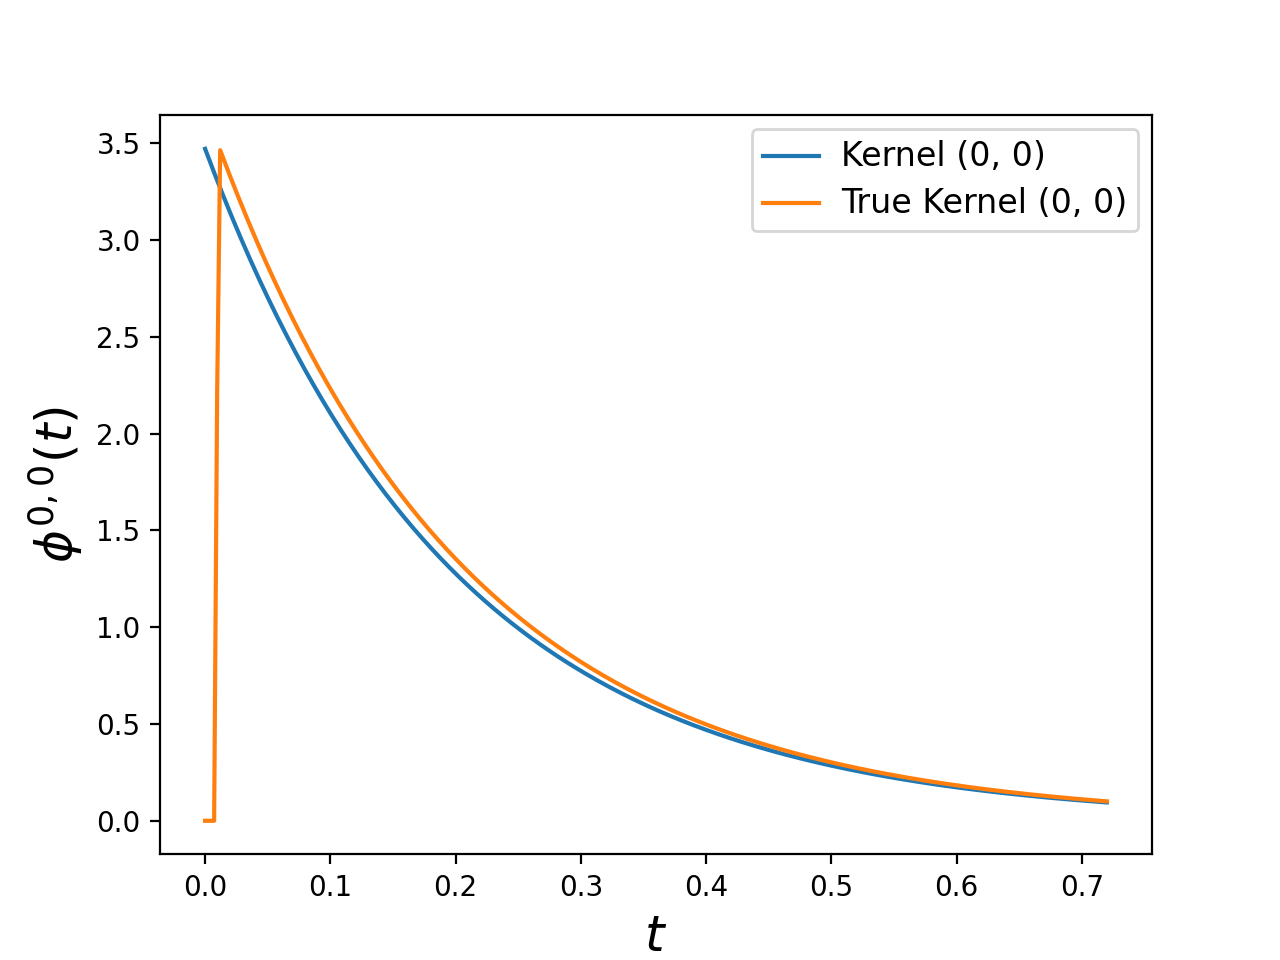

In [ ]:
plot_hawkes_kernels(sek_2, hawkes=hawkes_m2, log_scale=True)

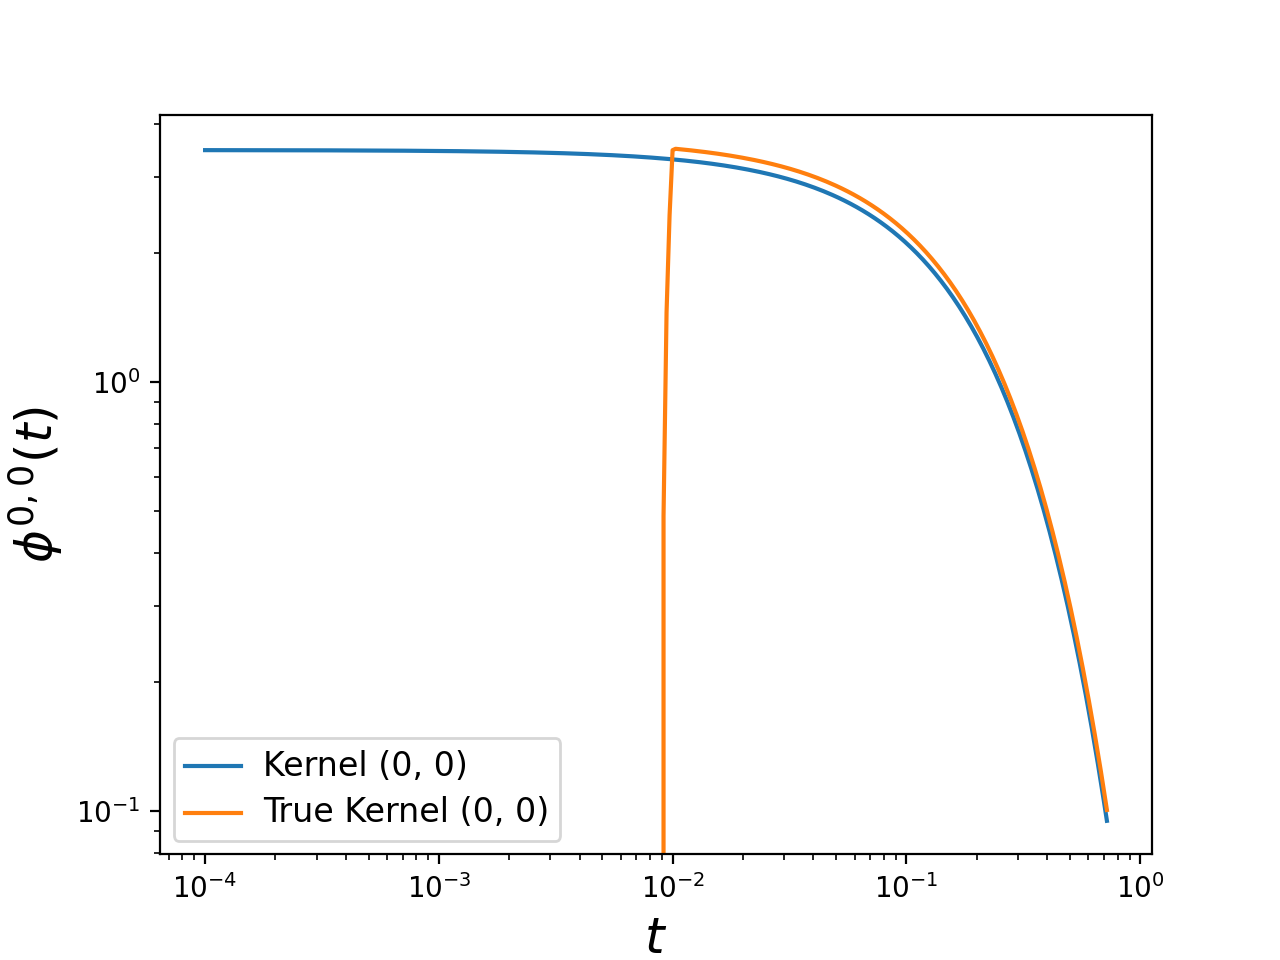

##### HawkesSumGaussians

In [ ]:
# sg_1 = HawkesSumGaussians(max_mean_gaussian=4, n_gaussians=7,
#                         lasso_grouplasso_ratio=0.5,
#                         max_iter=10000, tol=1e-5, C=1000., verbose=True)
# sg_1.fit(multi_1_timestamps)
# sg_1_baseline = sg_1.baseline
# sg_1_amplitudes = sg_1.amplitudes
# sg_1_means = sg_1.means_gaussians
# sg_1_std = sg_1.std_gaussian

# sg_2 = HawkesSumGaussians(max_mean_gaussian=4, n_gaussians=7,
#                         lasso_grouplasso_ratio=0.5,
#                         max_iter=10000, tol=1e-5, C=1000., verbose=True)
# sg_2.fit(multi_2_timestamps)
# sg_2_baseline = sg_2.baseline
# sg_2_amplitudes = sg_2.amplitudes
# sg_2_means = sg_2.means_gaussians
# sg_2_std = sg_2.std_gaussian

In [ ]:
# plot_hawkes_kernels(sg, hawkes=hawkes_m)